In [1]:
import re
import pandas as pd 
import numpy as np 
import random 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 

In [2]:
df = pd.read_csv("src/data/newsdatasetshuffle_4000.csv")
raw_data = df.iloc[:,3:].drop('timestamp', axis=1)
raw_data.head()

,title,label
0,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",industri
1,"Secuplik Nestapa Ethiopia, Negara Miskin yang ...",perang
2,Ssstt!! Ini Rahasia Tajir Jual-Beli Properti,properti
3,Menteri Era SBY Yakin Nadiem Makarim Majukan P...,teknologi
4,"Dewan Kolonel Vs Dewan Kopral, Perang Dukungan...",perang


In [3]:
raw_data = raw_data.astype(str)

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
len(stopwords_ind)

758

In [5]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text
raw_data

,title,label
0,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",industri
1,"Secuplik Nestapa Ethiopia, Negara Miskin yang ...",perang
2,Ssstt!! Ini Rahasia Tajir Jual-Beli Properti,properti
3,Menteri Era SBY Yakin Nadiem Makarim Majukan P...,teknologi
4,"Dewan Kolonel Vs Dewan Kopral, Perang Dukungan...",perang
...,...,...
3995,"Mudahkan Penanaman Modal di IKN, Pemerintah Si...",pemerintahan
3996,Warning! IMF Pangkas Proyeksi Ekonomi Dunia 20...,properti
3997,Mencekam! Pasukan Kurdi Kontak Senjata Lawan I...,perang
3998,10 Fakta Menarik Wajib Militer di Korea Selatan,pemerintahan


In [6]:
def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

%time
raw_data['title'] = raw_data['title'].apply(text_preprocessing)
raw_data['title'] = raw_data['title'].apply(remove_stop_words)
raw_data['title'] = raw_data['title'].apply(stemming)

Wall time: 0 ns


In [7]:
raw_data.head()

,title,label
0,stok gula aman pabrik makan ngebut,industri
1,cuplik nestapa ethiopia negara miskin jebak pe...,perang
2,ssstt rahasia tajir jualbeli properti,properti
3,menteri era sby nadiem makarim maju didik ri,teknologi
4,dewan kolonel vs dewan kopral perang dukung pu...,perang


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
raw_data['label'] = le.fit_transform(raw_data['label'])

In [9]:
raw_data.head()

,title,label
0,stok gula aman pabrik makan ngebut,0
1,cuplik nestapa ethiopia negara miskin jebak pe...,2
2,ssstt rahasia tajir jualbeli properti,3
3,menteri era sby nadiem makarim maju didik ri,4
4,dewan kolonel vs dewan kopral perang dukung pu...,2


In [10]:
le.classes_

array(['industri', 'pemerintahan', 'perang', 'properti', 'teknologi'],
      dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(raw_data, test_size=0.15,random_state=10)
df_val, df_test = train_test_split(df_test, test_size=0.5,random_state=10)

df_train.shape, df_test.shape, df_val.shape

((3400, 2), (300, 2), (300, 2))

In [12]:
PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [13]:
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))

Panjang vocabulary: 30521


In [14]:
print('Kalimat:', raw_data.title[10])
print('BERT Tokenizer:', bert_tokenizer.tokenize(raw_data.title[10]))

Kalimat: anakanak lansia lviv ukraina latih senjata
BERT Tokenizer: ['anakanak', 'lansia', 'lv', '##iv', 'ukraina', 'latih', 'senjata']


In [15]:
bert_input = bert_tokenizer.encode_plus(
    raw_data.title[10],             # Sample kalimat                
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 40,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
print('Kalimat\t\t:', raw_data.title[10])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])                                # Attention mask : mengembalikan nilai [0,1]. 1 artinya token yang di masking, 0 token yang tidak di masking (diabaikan)

Kalimat		: anakanak lansia lviv ukraina latih senjata
Tokenizer	: ['[CLS]', 'anakanak', 'lansia', 'lv', '##iv', 'ukraina', 'latih', 'senjata', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [2, 1739, 12919, 24116, 624, 20803, 21546, 4481, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask	: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


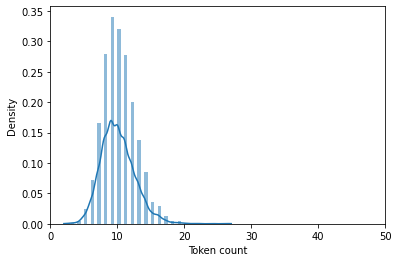

In [17]:
# Menentukan Max Length
token_lens = []

for txt in raw_data.title:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 50]);
plt.xlabel('Token count');

In [18]:
# ENCODE
MAX_LEN = 40
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )
  
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [19]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 7e-5

In [20]:
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [21]:
from transformers import TFBertForSequenceClassification,BertConfig



# Load model
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL)
config.num_labels = 5
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, config=config)
# bert_model.hidden_dropout_prob = 0.25
# bert_model.attention_probs_dropout_prob = 0.25

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.experimental.AdamW(lr = LEARNING_RATE, weight_decay = 1e-2)
# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile modelLEARNING_RATE
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [23]:
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/5
107/107 [==============================] - 351s 3s/step - loss: 0.7406 - accuracy: 0.7306 - val_loss: 0.4627 - val_accuracy: 0.8300
Epoch 2/5
107/107 [==============================] - 352s 3s/step - loss: 0.4520 - accuracy: 0.8488 - val_loss: 0.5262 - val_accuracy: 0.8167
Epoch 3/5
107/107 [==============================] - 354s 3s/step - loss: 0.3672 - accuracy: 0.8788 - val_loss: 0.5364 - val_accuracy: 0.8133
Epoch 4/5
107/107 [==============================] - 352s 3s/step - loss: 0.3058 - accuracy: 0.9085 - val_loss: 0.7496 - val_accuracy: 0.7867
Epoch 5/5
107/107 [==============================] - 365s 3s/step - loss: 0.2734 - accuracy: 0.9156 - val_loss: 0.7193 - val_accuracy: 0.7967


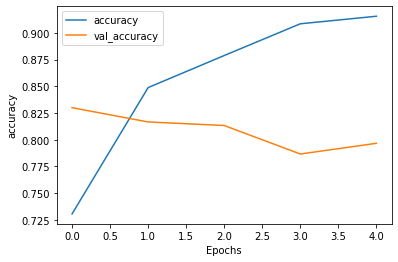

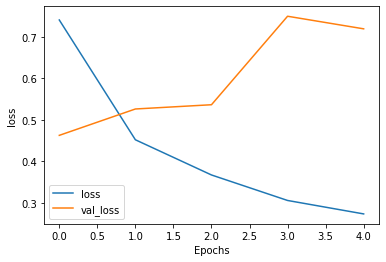

In [24]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [37]:
bert_model.save_weights('model/bert-model_rs10_new.h5')

In [39]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

10/10 [==============================] - 11s 1s/step - loss: 1.1646 - accuracy: 0.7133
Test Accuracy: 0.7133333086967468


In [27]:
# Sample text
input_text = 'Waduh... Pabrik Batu Bara di Inggris Dihancurkan, Kenapa?'

# Encode input text
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [28]:
bert_predict = bert_model(input_text_tokenized)          # Lakukan prediksi
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         # Softmax function untuk mendapatkan hasil klasifikasi
label = tf.argmax(bert_output, axis=1)
label = label.numpy()
print(label)

[0]


In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
le.classes_

array(['industri', 'pemerintahan', 'perang', 'properti', 'teknologi'],
      dtype=object)

In [31]:
df_test.head()

,title,label
2515,ekonom top dunia krisis ngeri,2
3263,manajemen kontraktor muka rampung apartemen ke...,3
775,psi pecat suprapti jual dawet kanjuruhan,1
705,pakai makam teknologi chatbot ngobrol orang ti...,4
85,tumbuh bca revisi target kredit lompat,3


In [32]:
def predict_test(data):
    predict_y = []
    for i in data:
        input_text_tokenized = bert_tokenizer.encode(i,
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='tf')
        bert_predict = bert_model(input_text_tokenized)
        bert_output = tf.nn.softmax(bert_predict[0], axis=-1)
        label = tf.argmax(bert_output, axis=1)
        label = label.numpy()
        predict_y.append(label)
    return predict_y

predict_y = predict_test(df_test['title'].values)
        

In [33]:
y = classification_report(df_test['label'].values,predict_y)

In [34]:
print(classification_report(df_test['label'].values,predict_y,target_names=le.classes_))

              precision    recall  f1-score   support

    industri       0.47      0.85      0.61        53
pemerintahan       0.86      0.61      0.71        71
      perang       0.72      0.81      0.76        62
    properti       0.92      0.62      0.74        56
   teknologi       0.85      0.71      0.77        58

    accuracy                           0.71       300
   macro avg       0.77      0.72      0.72       300
weighted avg       0.77      0.71      0.72       300



In [35]:
print(type(df_test['label'].values[0]))
print(type(predict_y[0]))

<class 'numpy.int32'>
<class 'numpy.ndarray'>


[Text(0, 0.5, 'industri'),
 Text(0, 1.5, 'pemerintahan'),
 Text(0, 2.5, 'perang'),
 Text(0, 3.5, 'properti'),
 Text(0, 4.5, 'teknologi')]

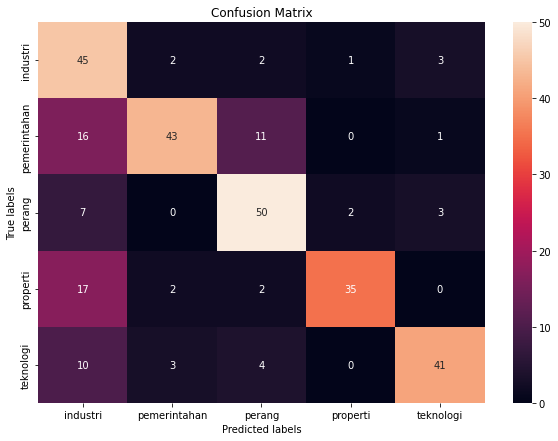

In [36]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix(df_test['label'].values, predict_y),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)